<h1><center><b>Moneypoly</b></center></h1>

# **Contexto**

Esta es la segunda parte del desarrollo del prototipo "Moneypoly" 

Primera parte:

https://www.kaggle.com/code/maximilianoalarcon/hackathon-bbva-2022-eda-feature-engineering

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import math
import seaborn as sns

# **Carga de datos**

Este es el dataset procesado del notebook anterior

In [2]:
df_train = pd.read_csv("../input/hackathonbbva2022datadriven/train_v1.csv")
df_train.head()

,Fecha entrega del Informe,Tipo de vía,Departamento,Provincia,Distrito,Número de estacionamiento,Depósitos,Latitud (Decimal),Longitud (Decimal),Categoría del bien,Edad,Estado de conservación,Método Representado,Área Terreno,Área Construcción,Valor comercial (USD)
0,2020-02-16,CALLE,Piura,Piura,Veintiseis de Octubre,0.0,0.0,-5.163182,-80.682388,Vivienda Unifamiliar,0.0,En construcción,Costos o reposición (directo),62.50,62.50,25278
1,2019-05-21,CALLE,Lima,Lima,Surquillo,1.0,0.0,-12.115286,-77.003768,Departamento,1.0,Bueno,Comparación de mercado (directo),9.32,9.32,110807
2,2020-04-11,CALLE,Junín,Satipo,Satipo,0.0,0.0,-11.235446,-74.629221,Vivienda Unifamiliar,7.0,Regular,Costos o reposición (directo),126.00,126.00,42285
3,2016-05-24,CALLE,Lima,Lima,Santiago de Surco,0.0,0.0,-12.126384,-76.975707,Oficina,0.0,Bueno,Comparación de mercado (directo),8.60,8.60,165503
4,2016-01-12,AVENIDA,Lima,Lima,Lima,0.0,0.0,-12.089613,-76.994475,Vivienda Unifamiliar,43.0,Bueno,Comparación de mercado (directo),357.55,357.55,711009


In [3]:
df_train.columns

Index(['Fecha entrega del Informe', 'Tipo de vía', 'Departamento', 'Provincia',
       'Distrito', 'Número de estacionamiento', 'Depósitos',
       'Latitud (Decimal)', 'Longitud (Decimal)', 'Categoría del bien', 'Edad',
       'Estado de conservación', 'Método Representado', 'Área Terreno',
       'Área Construcción', 'Valor comercial (USD)'],
      dtype='object')

# **Agrupaciones**

Como habia dicho previamente, la distribucion asimetrica del valor (usd) requiere una agrupacion previa para reducir el margen de error en las proyecciones

En particular las agrupaciones se realizaran a partir de las columnas "Categoría del bien","Método Representado","Estado de conservación" porque:

* Categoría del bien -> distingue la usabilidad en cada bien y eso define su capitalizacion
* Método Representado -> es el metodo utilizado para calcular el valor (usd), es un filtro para designar un estimador para cada metodo
* Estado de conservación -> Es un dato que distingue la calidad de los bienes e influye en su capitalizacion

('AVALUOS_TIPOS_INMUEBLE_VEHICULO', 'Comparación de mercado (directo)', 'Bueno')


<Figure size 1440x936 with 0 Axes>

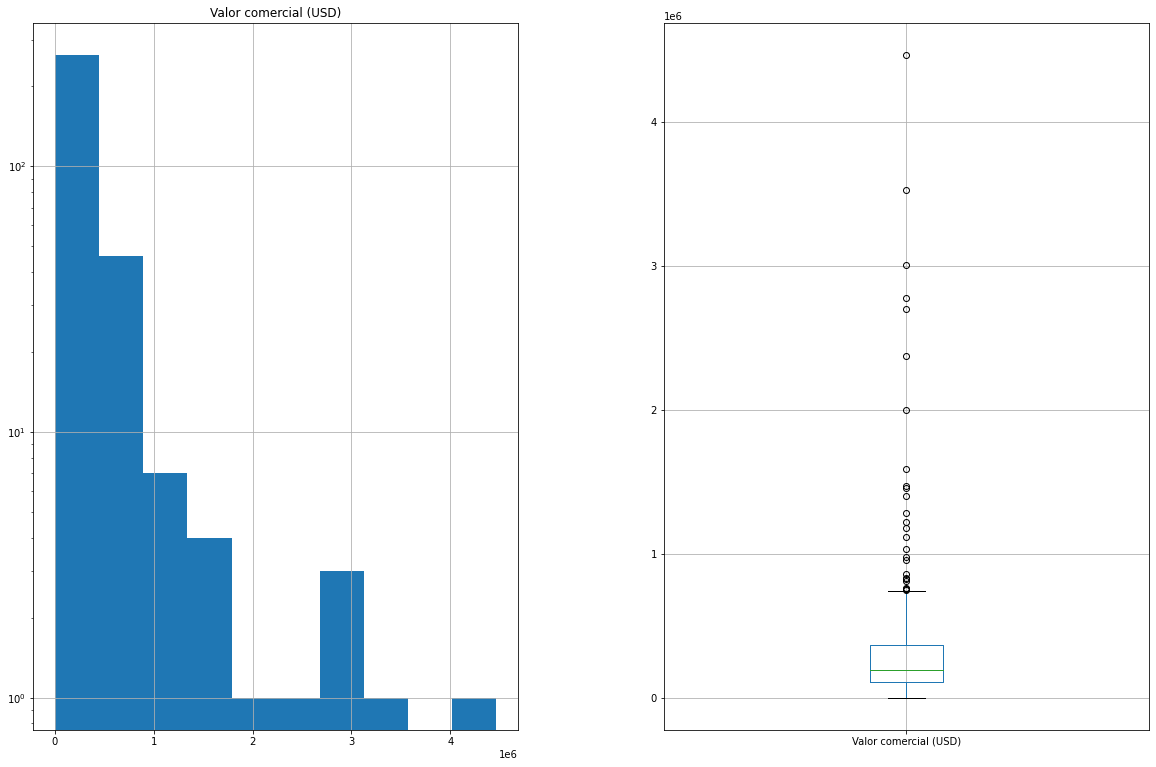

('AVALUOS_TIPOS_INMUEBLE_VEHICULO', 'Comparación de mercado (directo)', 'En construcción')


<Figure size 1440x936 with 0 Axes>

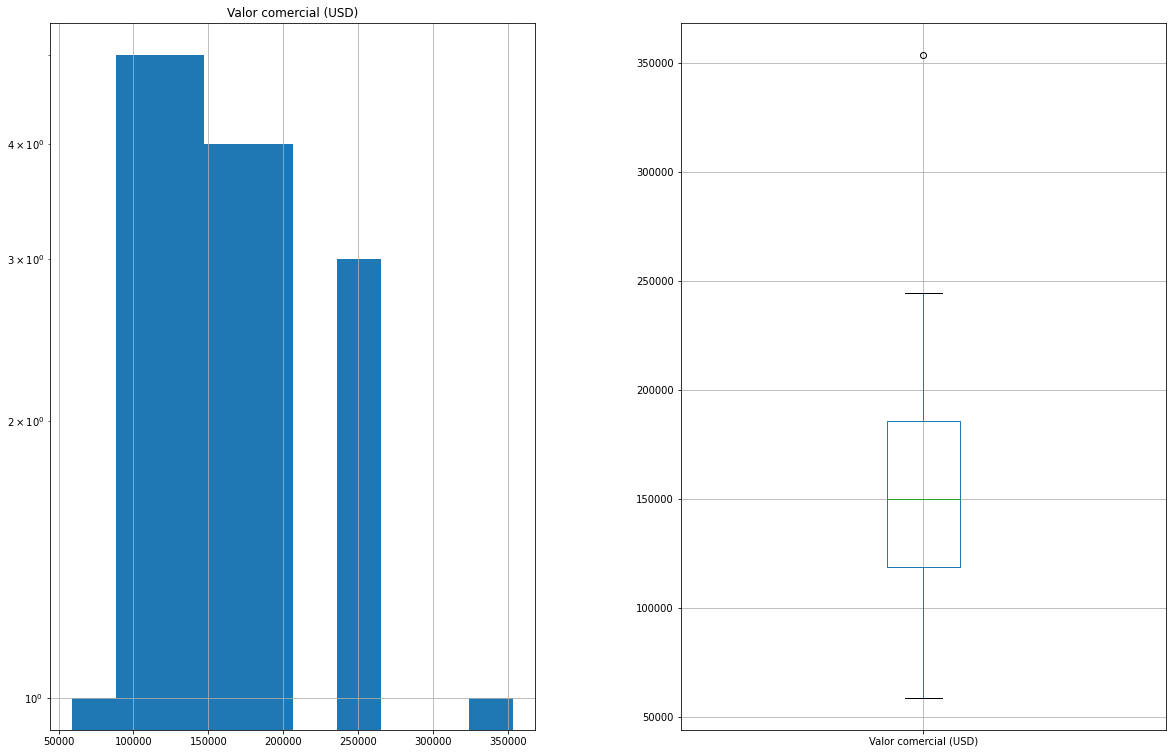

('AVALUOS_TIPOS_INMUEBLE_VEHICULO', 'Comparación de mercado (directo)', 'En proyecto')


<Figure size 1440x936 with 0 Axes>

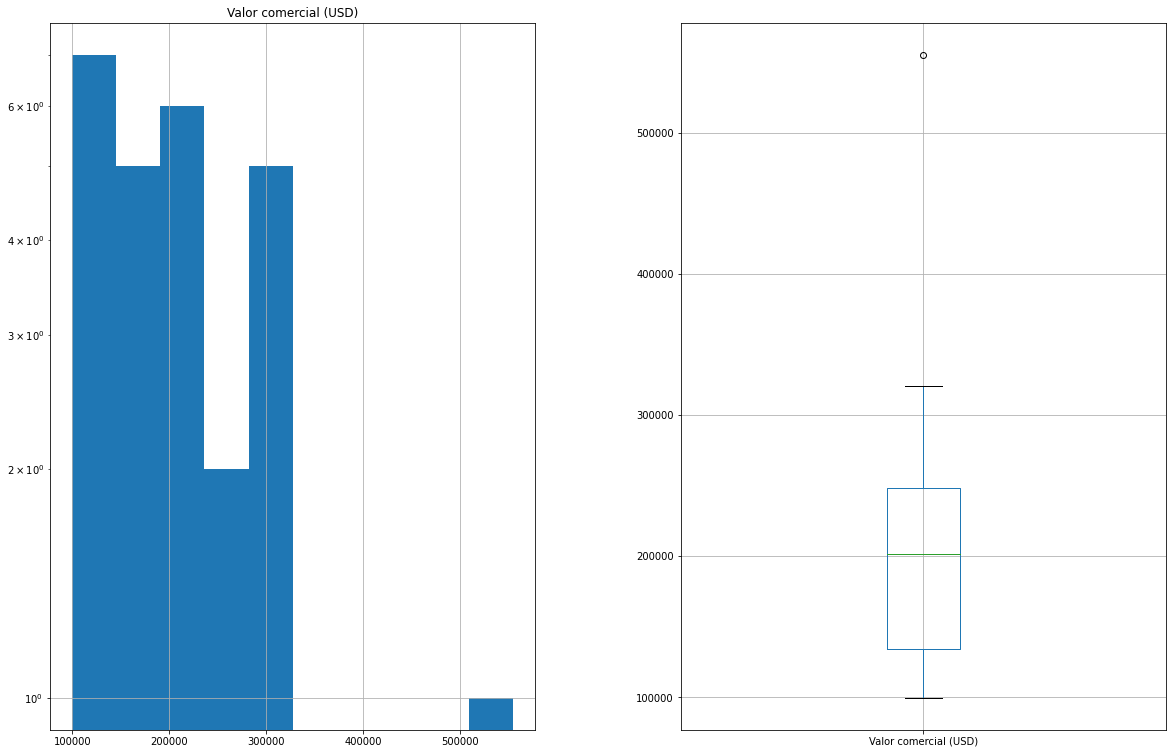

('AVALUOS_TIPOS_INMUEBLE_VEHICULO', 'Comparación de mercado (directo)', 'Muy bueno')


<Figure size 1440x936 with 0 Axes>

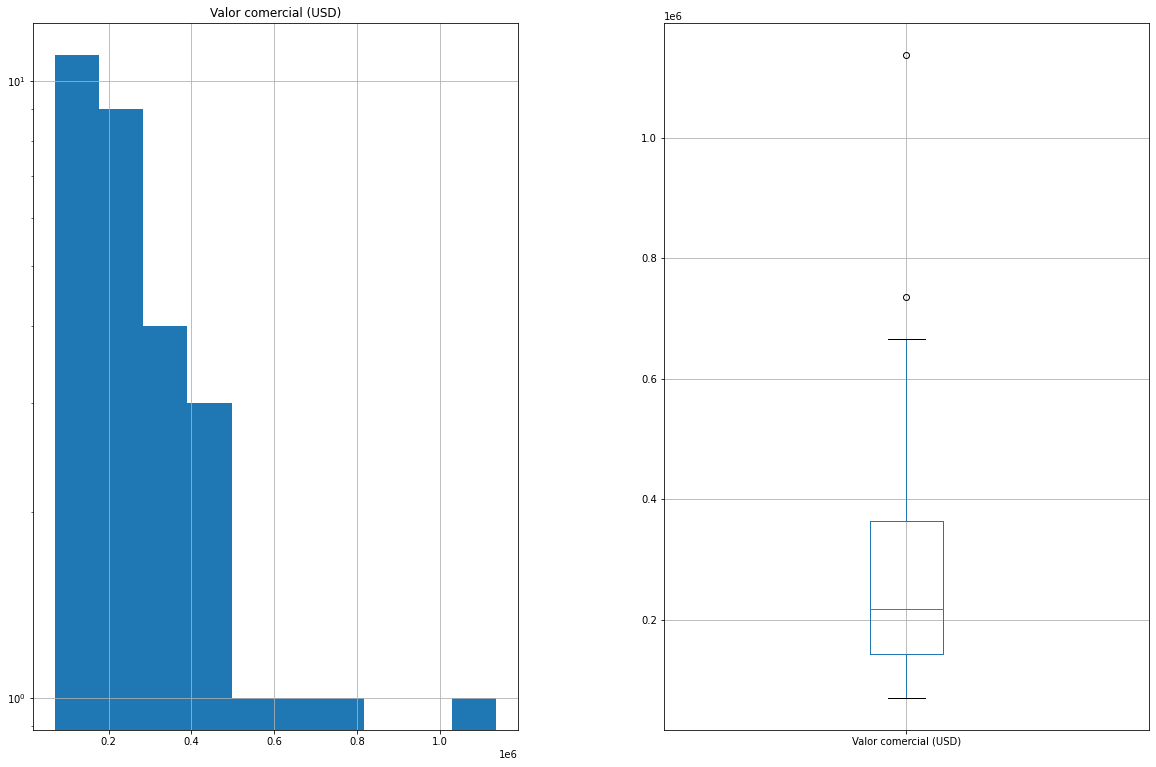

('AVALUOS_TIPOS_INMUEBLE_VEHICULO', 'Comparación de mercado (directo)', 'Regular')


<Figure size 1440x936 with 0 Axes>

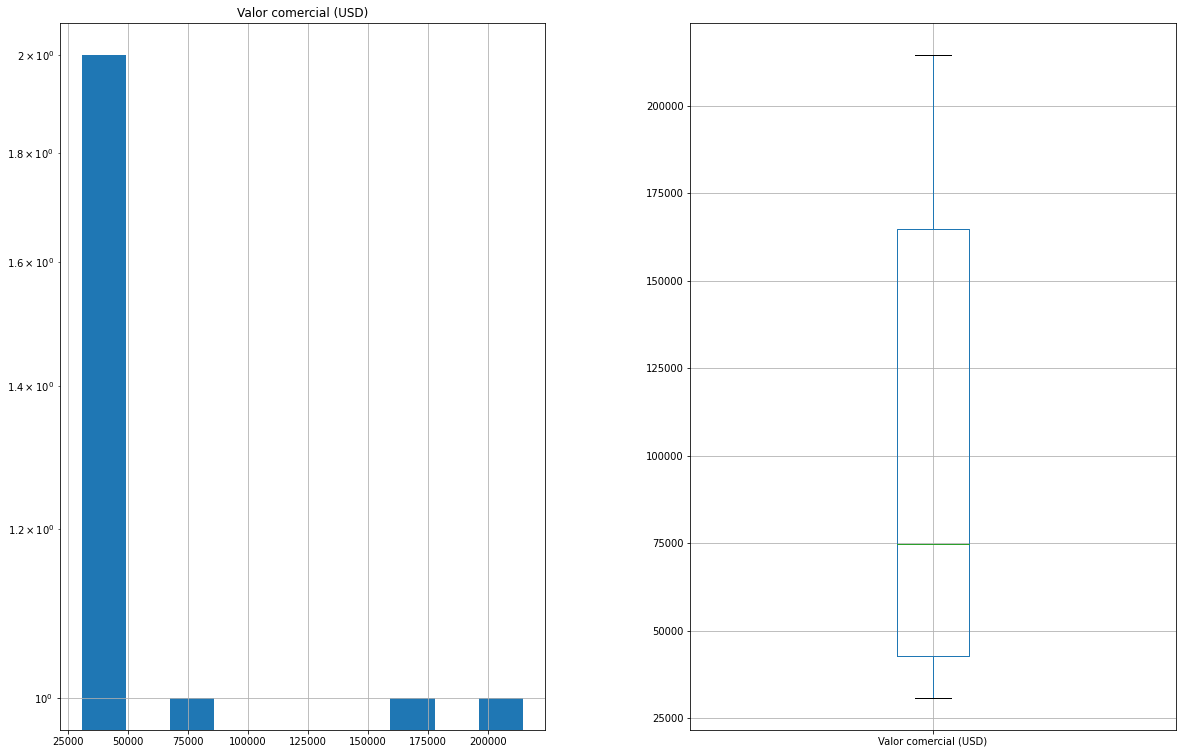

In [4]:
cols_cat = ["Categoría del bien","Método Representado","Estado de conservación"]
col_num = "Valor comercial (USD)"
suma = 0
for index,group in df_train.groupby(cols_cat):
    if suma < 5:
        print(index)
        plt.figure(figsize=(20,13))
        fig, axes = plt.subplots(1, 2, figsize=(20,13))
        group.hist(column=[col_num],ax=axes[0],log=True)
        group.boxplot(column=[col_num],ax=axes[1])
        plt.show()
    suma += 1

Funciones auxiliares

In [5]:
def number_betweeen_in_range(num,since,until):
    return (num >= since) and (num <= until)

def extraer_valores_principales(column,rango=(0.7,1.3)):
    lista_valores = column.values.reshape(1, -1).ravel().tolist()
    lista_extraida = []
    if len(lista_valores) >= 3:    
        for i in range(len(lista_valores)-2):
            i_1 = i
            i_2 = i+2
            cociente = lista_valores[i_1:i_2][0]/ lista_valores[i_1:i_2][1]
            if  number_betweeen_in_range(cociente,rango[0],rango[1]):
                lista_extraida.append(lista_valores[i_1:i_2][0])
            else:
                lista_extraida.append(lista_valores[i_1:i_2][0])
                break;
    else:
        lista_extraida.append(lista_valores[0])

    if len(lista_extraida) < 1:
        lista_extraida.append(lista_valores[0])
    return lista_extraida

# **Busquedas adyacentes**

Una vez realizado la agrupacion, el proximo paso es aplicar una busqueda de registros "similares" por distancia.
A partir de alli calcular el promedio de los registros "mas" cercanos

Habra una busqueda por cada metodo de valorizacion

# **Costo o reposicion**

Busqueda a partir de:

'Área Construcción','Área Terreno',"Edad",'Número de estacionamiento',"Depósitos"

In [6]:
def estimacion_por_costo(group,ejemplar):
    cols_costo = ['Área Construcción','Área Terreno',"Edad",'Número de estacionamiento',"Depósitos"]
    target = ["Valor comercial (USD)"]
    dataset_costo = group[cols_costo+target].copy()
    for c in cols_costo:
        dataset_costo[c] = abs(dataset_costo[c]-ejemplar[c])
    dataset_costo.sort_values(cols_costo,inplace=True)
    estimacion = 0
    suma_diff = 0
    for c in cols_costo:
        suma_diff +=  dataset_costo[c].iloc[0]
    if suma_diff == 0:
        estimacion = dataset_costo.iloc[0,len(cols_costo)+len(target)-1]
    else:
        estimacion = np.mean(extraer_valores_principales(dataset_costo["Valor comercial (USD)"]))
    return estimacion

# **Comparacion de mercado**

Busqueda a partir de:

'Latitud (Decimal)', 'Longitud (Decimal)', 'Edad', 'Área Terreno', 'Área Construcción'

In [7]:
def estimacion_por_comparacion(group,ejemplar):
    
    departamento = ejemplar["Departamento"]
    provincia = ejemplar["Provincia"]
    distrito = ejemplar["Distrito"]
    
    mask_1 = group["Departamento"] == departamento
    mask_2 = group["Provincia"] == provincia
    mask_3 = group["Distrito"] == distrito
    if sum(mask_1*mask_2*mask_3) > 0:
        group = group[mask_1*mask_2*mask_3]
    elif sum(mask_1*mask_2) > 0:
        group = group[mask_1*mask_2]
    elif sum(mask_1) > 0:
        group = group[mask_1]
    
    cols_costo = ['Latitud (Decimal)', 'Longitud (Decimal)', 'Edad', 'Área Terreno', 'Área Construcción']
    target = ["Valor comercial (USD)"]
    dataset_costo = group[cols_costo+target].copy()
    for c in cols_costo:
        dataset_costo[c] = abs(dataset_costo[c]-ejemplar[c])
    dataset_costo.sort_values(cols_costo,inplace=True)
    estimacion = 0
    suma_diff = 0
    for c in cols_costo:
        suma_diff +=  dataset_costo[c].iloc[0]
    if suma_diff == 0:
        estimacion = dataset_costo.iloc[0,len(cols_costo)+len(target)-1]
    else:
        estimacion = np.mean(extraer_valores_principales(dataset_costo["Valor comercial (USD)"]))
    return estimacion

# **Renta o capitalizacion**

Busqueda a partir de:

"Edad",'Área Terreno','Área Construcción','Número de estacionamiento',"Depósitos"

In [8]:
def estimacion_por_renta_capitalizacion(group,ejemplar):
    
    tipo_via = ejemplar["Tipo de vía"]
    mask_1 = group["Tipo de vía"] == tipo_via
    if sum(mask_1) > 0:
        group = group[mask_1]
    
    cols_costo = ["Edad",'Área Terreno','Área Construcción','Número de estacionamiento',"Depósitos"]
    target = ["Valor comercial (USD)"]
    dataset_costo = group[cols_costo+target].copy()
    for c in cols_costo:
        dataset_costo[c] = abs(dataset_costo[c]-ejemplar[c])
    dataset_costo.sort_values(cols_costo,inplace=True)
    estimacion = 0
    suma_diff = 0
    for c in cols_costo:
        suma_diff +=  dataset_costo[c].iloc[0]
    if suma_diff == 0:
        estimacion = dataset_costo.iloc[0,len(cols_costo)+len(target)-1]
    else:
        estimacion = np.mean(extraer_valores_principales(dataset_costo["Valor comercial (USD)"]))
    return estimacion

# **Transformacion de datos**

Este es el paso previo a la proyeccion, la transformacion de datos desarrollada en la presentacion anterior:

https://www.kaggle.com/code/maximilianoalarcon/hackathon-bbva-2022-eda-feature-engineering

El modelo precisara un modulo de transformacion automatizada resumida en los siguientes bloques de codigo

Este es un ejemplar del dataset de evaluacion.

Contiene valores nulos y categorias no vistas previamente

In [9]:
df_test = pd.read_excel("../input/hackathonbbva2022datadriven/dataset_test_pruebas.xlsx")
df_test.head(15)

,ID,Fecha entrega del Informe,Tipo de vía,Piso,Departamento,Provincia,Distrito,Número de estacionamiento,Depósitos,Latitud (Decimal),...,Categoría del bien,Posición,Número de frentes,Edad,Elevador,Estado de conservación,Método Representado,Área Terreno,Área Construcción,Valor comercial (USD)
0,1.0,2021-05-21,1.0,NaN,Lima,Lima,Surquillo,0.0,1.0,-12.105644,...,Departamento,NaN,NaN,1.0,NaN,Bueno,Comparación de mercado (directo),11.0,64.92,NaN
1,2.0,2017-11-26,2.0,NaN,Lima,Lima,Santiago de Surco,1.0,1.0,-12.138068,...,Departamento,NaN,NaN,1.0,NaN,Muy bueno,Comparación de mercado (directo),50.32,134.20,NaN
2,3.0,2019-03-01,3.0,NaN,Apurímac,Chincheros,Chincheros,1.0,1.0,NaN,...,Oficina,NaN,NaN,1.0,NaN,Bueno,Comparación de mercado (directo),2022-08-05 00:00:00,111.11,NaN
3,4.0,2019-11-22,2.0,NaN,Ucayali,Coronel Portillo,Calleria,NaN,NaN,-8.381362,...,Terreno Urbano,NaN,NaN,NaN,NaN,NaN,Costos o reposición (directo),31.0,0.00,NaN
4,5.0,2020-10-16,1.0,NaN,Lima,Lima,Magdalena del Mar,1.0,2.0,-12.091392,...,NaN,NaN,NaN,2.0,NaN,En proyecto,Comparación de mercado (directo),3.22,111.11,NaN
5,6.0,2021-06-05,NaN,NaN,Arequipa,Arequipa,Sachaca,1.0,2.0,-16.427006,...,Terreno Urbano,NaN,NaN,NaN,NaN,Bueno,Costos o reposición (directo),143.94,NaN,NaN
6,7.0,2017-07-07,NaN,NaN,Huancavelica,Huancavelica,Huancavelica,1.0,2.0,-14.074475,...,Local Comercial,NaN,NaN,3.0,NaN,Bueno,Costos o reposición (directo),NaN,90.88,NaN
7,8.0,2020-07-01,1.0,1.0,Lima,Lima,Surquillo,NaN,NaN,-12.117501,...,Departamento,NaN,NaN,2.0,NaN,En construcción,Comparación de mercado (directo),16.02,117.25,NaN
8,9.0,2019-08-22,2.0,NaN,Cusco,Chumbivilcas,Livitaca,1.0,2.0,-9.957866,...,Terreno Urbano,NaN,NaN,NaN,NaN,Bueno,Costos o reposición (directo),300.00,NaN,NaN
9,10.0,2017-09-13,1.0,NaN,Lima,Lima,La Molina,7.0,0.0,-12.076824,...,Vivienda Unifamiliar,NaN,NaN,19.0,NaN,Bueno,Comparación de mercado (directo),900.11,1200.98,NaN


In [10]:
types = {'Categoría del bien': 'object',
 'Depósitos': 'float64',
 'Edad': 'float64',
 'Estado de conservación': 'object',
 'Latitud (Decimal)': 'float64',
 'Longitud (Decimal)': 'float64',
 'Método Representado': 'object',
 'Número de estacionamiento': 'float64',
 'Área Construcción': 'float64',
 'Área Terreno': 'float64',
 'Tipo de vía': 'object',
 'Departamento': 'object',
 'Provincia': 'object',
 'Distrito': 'object'}


map_tipo_via = {
    1:"CALLE",
    2:"JIRON",
    3:"AVENIDA",
    4:"PASAJE",
    5:"CARRETERA",
    6:"MANZANA",
    7:"LOTE",
    8:"PARCELA",
    9:"FUNDO",
    10:"SIN_VIA",
    "1.0":"CALLE",
    "2.0":"JIRON",
    "3.0":"AVENIDA",
    "4.0":"PASAJE",
    "5.0":"CARRETERA",
    "6.0":"MANZANA",
    "7.0":"LOTE",
    "8.0":"PARCELA",
    "9.0":"FUNDO",
    "10.0":"SIN_VIA"
}

cant_decimales = 3

df_centros = pd.read_csv("../input/hackathonbbva2022datadriven/centros_lat_lon.csv")
departamentos_conocidos = list(df_centros["departamento"].unique())
df_centros.set_index(["departamento"],inplace=True)

categorias_conocidas = list(df_train["Categoría del bien"].unique())

means_areas = {}
for index,group in df_train.groupby(["Categoría del bien"]):
    means_areas[index] = {}
    means_areas[index]["mean_area_terreno"] = round(group["Área Terreno"].mean(),cant_decimales)
    means_areas[index]["mean_area_construccion"] = round(group["Área Construcción"].mean(),cant_decimales)

def validar_categoria(categoria):
    if categoria in categorias_conocidas:
        return categoria
    else:
        return "Departamento"
    
def validar_departamento(departamento):
    if departamento in departamentos_conocidos:
        return departamento
    else:
        return "Lima"    
    
def busqueda_latitud(x):
    return df_centros.loc[x["Departamento"]]["lat_median"]
    
def busqueda_longitud(x):
    return df_centros.loc[x["Departamento"]]["lon_median"]

def busqueda_area_terreno(categoria,area_construccion):
    mask1 = df_train["Categoría del bien"] == categoria
    mask2 = df_train["Área Terreno"].notnull()
    mask = mask1*mask2
    df_train_filtrado = df_train[mask].copy()
    df_train_filtrado["diff"] = abs(df_train_filtrado["Área Construcción"] - area_construccion)
    mask = df_train_filtrado["diff"] == df_train_filtrado["diff"].min()
    df_train_filtrado = df_train_filtrado[mask].copy()
    return df_train_filtrado["Área Terreno"].mean()

def busqueda_area_construccion(categoria,area_terreno):
    mask1 = df_train["Categoría del bien"] == categoria
    mask2 = df_train["Área Construcción"].notnull()
    mask = mask1*mask2
    df_train_filtrado = df_train[mask].copy()
    df_train_filtrado["diff"] = abs(df_train_filtrado["Área Terreno"] - area_terreno)
    mask = df_train_filtrado["diff"] == df_train_filtrado["diff"].min()
    df_train_filtrado = df_train_filtrado[mask].copy()
    return df_train_filtrado["Área Construcción"].mean()

def transformacion(df):
    df_copy = df.copy()
    atributos = ['Categoría del bien','Depósitos','Edad','Estado de conservación','Latitud (Decimal)','Longitud (Decimal)',
                 'Método Representado','Número de estacionamiento','Área Construcción','Área Terreno',"Tipo de vía","Departamento",
                 "Provincia","Distrito"]
    if "ID" in df.columns:
        atributos = ["ID"]+atributos
    df_copy = df_copy[atributos].copy()
    
    cols_categoricas = ["Categoría del bien","Estado de conservación","Método Representado","Tipo de vía","Departamento","Provincia","Distrito"]
    for c in cols_categoricas:
        if str(df_copy[c].dtypes) != types[c]:
            df_copy[c] = df_copy[c].astype("object")
            
    cols_numericas = ["Depósitos","Edad",'Número de estacionamiento','Área Construcción','Área Terreno']
    for c in cols_numericas:
        df_copy[c] = df_copy[c].astype(str)
        df_copy[c] = df_copy[c].str.replace(',','')
        df_copy[c] = pd.to_numeric(df_test[c],errors="coerce")
    
    cols_numericas_esp = ['Latitud (Decimal)','Longitud (Decimal)']
    for c in cols_numericas_esp:
        if df_copy[c].dtypes != "float64":
            df_copy[c] = df_copy[c].astype(str)
            df_copy[c] = df_copy[c].str.replace(',','')
            df_copy[c] = pd.to_numeric(df_test[c],errors="coerce")        
    
    df_copy["Tipo de vía"] = df_copy["Tipo de vía"].map(map_tipo_via)
    
    df_copy["Tipo de vía"] = df_copy["Tipo de vía"].fillna("CALLE")
    df_copy["Número de estacionamiento"] = df_copy["Número de estacionamiento"].fillna(0)
    df_copy["Depósitos"] = df_copy["Depósitos"].fillna(0)
    df_copy["Método Representado"] = df_copy["Método Representado"].fillna("Comparación de mercado (directo)")
    df_copy["Categoría del bien"] = df_copy["Categoría del bien"].fillna("Departamento")
    df_copy["Edad"] = df_copy["Edad"].fillna(0)
    df_copy["Estado de conservación"] = df_copy["Estado de conservación"].fillna("Bueno")
    
    df_copy["Departamento"] = df_copy["Departamento"].fillna("Lima")
    df_copy["Provincia"] = df_copy["Provincia"].fillna("Lima")
    df_copy["Distrito"] = df_copy["Distrito"].fillna("Santiago de Surco")
    
    
    #Imputacion de latitud y longitud
    lista_latitudes = []
    lista_longitudes = []
    for index,row in df_copy.iterrows():
        if pd.isnull(row["Latitud (Decimal)"]):     
            row["Departamento"] = validar_departamento(row["Departamento"])
            lista_latitudes.append(busqueda_latitud(row))
        else:
            lista_latitudes.append(row["Latitud (Decimal)"])
        if pd.isnull(row["Longitud (Decimal)"]):     
            row["Departamento"] = validar_departamento(row["Departamento"])
            lista_longitudes.append(busqueda_longitud(row))
        else:
            lista_longitudes.append(row["Longitud (Decimal)"])
    df_copy["Latitud (Decimal)"] = pd.Series(lista_latitudes)
    df_copy["Longitud (Decimal)"] = pd.Series(lista_longitudes)
    
    
    #Imputacion de areas construccion
    mask1 = df_copy["Área Construcción"].isnull()
    mask2 = df_copy["Categoría del bien"].notnull()
    mask3 = df_copy["Área Terreno"].notnull()
    mask = mask1*mask2*mask3
    areas_construcciones = []
    if sum(mask) > 0:
        df_copy["mask"] = mask
        for index,row in df_copy.iterrows():
            if row["mask"]:
                busqueda = busqueda_area_construccion(validar_categoria(row["Categoría del bien"]),row["Área Terreno"])
                areas_construcciones.append(round(busqueda,cant_decimales))
            else:
                areas_construcciones.append(round(row["Área Construcción"],cant_decimales))
        df_copy["Área Construcción"] = areas_construcciones
        df_copy.drop(["mask"],inplace=True,axis=1)
    
    
    #Imputacion de areas terrenos
    mask1 = df_copy["Área Terreno"].isnull()
    mask2 = df_copy["Categoría del bien"].notnull()
    mask3 = df_copy["Área Construcción"].notnull()
    mask = mask1*mask2*mask3
    areas_terrenos = []
    if sum(mask) > 0:
        df_copy["mask"] = mask
        for index,row in df_copy.iterrows():
            if row["mask"]:
                busqueda = busqueda_area_terreno(validar_categoria(row["Categoría del bien"]),row["Área Construcción"])
                areas_terrenos.append(round(busqueda,cant_decimales))
            else:
                areas_terrenos.append(round(row["Área Terreno"],cant_decimales))
        df_copy["Área Terreno"] = areas_terrenos
        df_copy.drop(["mask"],inplace=True,axis=1)
    
    return df_copy

    mask1 = df_copy["Área Terreno"].isnull()
    mask2 = df_copy["Área Construcción"].isnull()
    mask = mask1*mask2
    areas_terrenos = []
    areas_construcciones = []
    if sum(mask) > 0:
        df_copy["mask"] = mask
        for index,row in df_copy.iterrows():
            if row["mask"]:
                row["Categoría del bien"] = validar_categoria(row["Categoría del bien"])
                areas_terrenos.append(means_areas[row["Categoría del bien"]]["mean_area_terreno"])
                areas_construcciones.append(means_areas[row["Categoría del bien"]]["mean_area_construccion"])
        df_copy["Área Terreno"] = areas_terrenos
        df_copy["Área Construcción"] = areas_construcciones
    

print("Nulos en dataset original")
print(df_test.isnull().sum())
print("")
df_test_transformed = transformacion(df_test)
print("Nulos en dataset transformado")
print(df_test_transformed.isnull().sum())
df_test_transformed.head(20)

Nulos en dataset original
ID                            0
Fecha entrega del Informe     0
Tipo de vía                   2
Piso                          9
Departamento                  0
Provincia                     0
Distrito                      0
Número de estacionamiento     2
Depósitos                     2
Latitud (Decimal)             1
Longitud (Decimal)            1
Categoría del bien            1
Posición                     10
Número de frentes            10
Edad                          3
Elevador                     10
Estado de conservación        1
Método Representado           0
Área Terreno                  1
Área Construcción             2
Valor comercial (USD)        10
dtype: int64

Nulos en dataset transformado
ID                           0
Categoría del bien           0
Depósitos                    0
Edad                         0
Estado de conservación       0
Latitud (Decimal)            0
Longitud (Decimal)           0
Método Representado          0
Número de 

,ID,Categoría del bien,Depósitos,Edad,Estado de conservación,Latitud (Decimal),Longitud (Decimal),Método Representado,Número de estacionamiento,Área Construcción,Área Terreno,Tipo de vía,Departamento,Provincia,Distrito
0,1.0,Departamento,1.0,1.0,Bueno,-12.105644,-77.025705,Comparación de mercado (directo),0.0,64.920,11.00,CALLE,Lima,Lima,Surquillo
1,2.0,Departamento,1.0,1.0,Muy bueno,-12.138068,-76.985660,Comparación de mercado (directo),1.0,134.200,50.32,JIRON,Lima,Lima,Santiago de Surco
2,3.0,Oficina,1.0,1.0,Bueno,-13.638792,-77.090878,Comparación de mercado (directo),1.0,111.110,113.30,AVENIDA,Apurímac,Chincheros,Chincheros
3,4.0,Terreno Urbano,0.0,0.0,Bueno,-8.381362,-74.537930,Costos o reposición (directo),0.0,0.000,31.00,JIRON,Ucayali,Coronel Portillo,Calleria
4,5.0,Departamento,2.0,2.0,En proyecto,-12.091392,-77.055850,Comparación de mercado (directo),1.0,111.110,3.22,CALLE,Lima,Lima,Magdalena del Mar
5,6.0,Terreno Urbano,2.0,0.0,Bueno,-16.427006,-71.573633,Costos o reposición (directo),1.0,145.155,143.94,CALLE,Arequipa,Arequipa,Sachaca
6,7.0,Local Comercial,2.0,3.0,Bueno,-14.074475,-76.014340,Costos o reposición (directo),1.0,90.880,90.86,CALLE,Huancavelica,Huancavelica,Huancavelica
7,8.0,Departamento,0.0,2.0,En construcción,-12.117501,-77.004499,Comparación de mercado (directo),0.0,117.250,16.02,CALLE,Lima,Lima,Surquillo
8,9.0,Terreno Urbano,2.0,0.0,Bueno,-9.957866,-76.243089,Costos o reposición (directo),1.0,174.809,300.00,JIRON,Cusco,Chumbivilcas,Livitaca
9,10.0,Vivienda Unifamiliar,0.0,19.0,Bueno,-12.076824,-76.931810,Comparación de mercado (directo),7.0,1200.980,900.11,CALLE,Lima,Lima,La Molina


# **Modelo**

Este es el modelo definitivo.

Se divide en 2 pasos:
* Filtrado por "Método Representado","Estado de conservación","Categoría del bien"
* Busqueda de adyacencia segun metodo de valorizacion

In [11]:
from tqdm import tqdm

def model(df):
    estimaciones = []
    for index,row in tqdm(df.iterrows(), total=df.shape[0]):
        metodo = row["Método Representado"]
        estado = row["Estado de conservación"]
        categoria = row["Categoría del bien"]
        mask_1 = df_train["Método Representado"] == metodo
        mask_2 = df_train["Estado de conservación"] == estado
        mask_3 = df_train["Categoría del bien"] == categoria
        group = None
        
        masks = []
        list_masks = {}
        masks.append({
            "indice":0,"suma":sum(mask_1*mask_2*mask_3)
        })
        list_masks[0] = mask_1*mask_2*mask_3
        masks.append({
            "indice":1,"suma":sum(mask_1*mask_2)
        })
        list_masks[1] = mask_1*mask_2
        masks.append({
            "indice":2,"suma":sum(mask_1*mask_3)
        })
        list_masks[2] = mask_1*mask_3
        masks.append({
            "indice":3,"suma":sum(mask_2*mask_3)
        })
        list_masks[3] = mask_2*mask_3
        masks.append({
            "indice":4,"suma":sum(mask_1)
        })
        list_masks[4] = mask_1
        masks.append({
            "indice":5,"suma":sum(mask_2)
        })
        list_masks[5] = mask_2
        masks.append({
            "indice":6,"suma":sum(mask_3)
        })
        list_masks[6] = mask_3
        masks = pd.DataFrame(masks)
        masks = masks[masks["suma"] > 0]
        masks.sort_values(["suma"],inplace=True)
        if masks.shape[0] > 0:
            group = df_train[list_masks[masks["indice"][0]]]
        else:
            group = df_train.copy()
        
        if metodo == "Costos o reposición (directo)":
            estimaciones.append(int(estimacion_por_costo(group,row)))    
        elif metodo == "Comparación de mercado (directo)":
            estimaciones.append(int(estimacion_por_comparacion(group,row))) 
        elif metodo == "Renta o capitalización (indirecto)":
            estimaciones.append(int(estimacion_por_renta_capitalizacion(group,row)))
        else:
            estimaciones.append(int(estimacion_por_comparacion(group,row)))
    return estimaciones

In [12]:
preds = model(df_test_transformed)
df_test_transformed["Valor comercial (USD)"] = preds
df_test_transformed.head(20)

100%|██████████| 10/10 [00:00<00:00, 13.74it/s]


,ID,Categoría del bien,Depósitos,Edad,Estado de conservación,Latitud (Decimal),Longitud (Decimal),Método Representado,Número de estacionamiento,Área Construcción,Área Terreno,Tipo de vía,Departamento,Provincia,Distrito,Valor comercial (USD)
0,1.0,Departamento,1.0,1.0,Bueno,-12.105644,-77.025705,Comparación de mercado (directo),0.0,64.920,11.00,CALLE,Lima,Lima,Surquillo,112742
1,2.0,Departamento,1.0,1.0,Muy bueno,-12.138068,-76.985660,Comparación de mercado (directo),1.0,134.200,50.32,JIRON,Lima,Lima,Santiago de Surco,215609
2,3.0,Oficina,1.0,1.0,Bueno,-13.638792,-77.090878,Comparación de mercado (directo),1.0,111.110,113.30,AVENIDA,Apurímac,Chincheros,Chincheros,239814
3,4.0,Terreno Urbano,0.0,0.0,Bueno,-8.381362,-74.537930,Costos o reposición (directo),0.0,0.000,31.00,JIRON,Ucayali,Coronel Portillo,Calleria,1345584
4,5.0,Departamento,2.0,2.0,En proyecto,-12.091392,-77.055850,Comparación de mercado (directo),1.0,111.110,3.22,CALLE,Lima,Lima,Magdalena del Mar,125799
5,6.0,Terreno Urbano,2.0,0.0,Bueno,-16.427006,-71.573633,Costos o reposición (directo),1.0,145.155,143.94,CALLE,Arequipa,Arequipa,Sachaca,259284
6,7.0,Local Comercial,2.0,3.0,Bueno,-14.074475,-76.014340,Costos o reposición (directo),1.0,90.880,90.86,CALLE,Huancavelica,Huancavelica,Huancavelica,271580
7,8.0,Departamento,0.0,2.0,En construcción,-12.117501,-77.004499,Comparación de mercado (directo),0.0,117.250,16.02,CALLE,Lima,Lima,Surquillo,173194
8,9.0,Terreno Urbano,2.0,0.0,Bueno,-9.957866,-76.243089,Costos o reposición (directo),1.0,174.809,300.00,JIRON,Cusco,Chumbivilcas,Livitaca,6440
9,10.0,Vivienda Unifamiliar,0.0,19.0,Bueno,-12.076824,-76.931810,Comparación de mercado (directo),7.0,1200.980,900.11,CALLE,Lima,Lima,La Molina,1180678
